# Analiza danych przejazdów autobusów ZTM

Importowanie bibliotek

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

Importowanie własnej biblioteki

In [2]:
import spacial_data_analysis_ztm

Ładowanie wcześniej ściągniętych danych zapisanych ze środka nocy 28.06.2021
Funkcja ta również usuwa duplikaty i konwertuje czas zapisany w ciągu znaków na pandas datetime

In [3]:
df_night = spacial_data_analysis_ztm.load_files_directory_into_df('data/28.06.2021_night_minute')

data/28.06.2021_night_minute
FInished importing files


Konwertowanie Lon i Lat (długość i szerokość geograficzna) z DataFrame na typ POINT w GeoDataFrame (rozbudowane DataFrame z biblioteki Geopandas).

In [4]:
# oryginalny CRS ze strony ztm crs='EPSG:4326'
ztm_crs = 'EPSG:4326'

In [5]:
gdf_night = spacial_data_analysis_ztm.covert_long_lat_into_geodataframe(df_night, ztm_crs)

Sprawdzanie czy dane zostały załadowanie

In [6]:
gdf_night.head()

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,Unnamed: 0,geometry
0,213,21.115615,1000,2021-06-27 23:51:33,52.234600,2,0.0,POINT (21.11562 52.23460)
1,213,21.115168,1001,2021-06-28 00:30:59,52.234600,3,1.0,POINT (21.11517 52.23460)
2,213,21.114898,1003,2021-06-27 00:02:20,52.234726,1,2.0,POINT (21.11490 52.23473)
3,213,21.115269,1005,2021-06-27 23:19:40,52.234594,4,3.0,POINT (21.11527 52.23459)
4,130,21.115590,1008,2021-06-25 20:19:05,52.234613,04,4.0,POINT (21.11559 52.23461)


Konwertowanie zapisu przestrzennego z CRS na projected CRS (potrzebne do obliczania odległości)

In [7]:
gdf_night = gdf_night.to_crs(epsg=2178)

In [8]:
gdf_night.crs

<Projected CRS: EPSG:2178>
Name: ETRS89 / Poland CS2000 zone 7
Axis Info [cartesian]:
- x[north]: Northing (metre)
- y[east]: Easting (metre)
Area of Use:
- name: Poland - onshore and offshore between 19°30'E and 22°30'E.
- bounds: (19.5, 49.09, 22.5, 54.55)
Coordinate Operation:
- name: Poland CS2000 zone 7
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich


Sortowanie GeoDataFrame ze względu na kolumny VehicleNumber i Time

In [9]:
gdf_night = spacial_data_analysis_ztm.sort_vehicle_number_time(gdf_night)

Usuwanie duplikotów bazując na bazując na VehicleNumber i Time

In [10]:
gdf_night = spacial_data_analysis_ztm.remove_duplicates(gdf_night)


Usuwanie tych pojazdów (vehlcle), które występują tylko jeden raz (nie da się nic policzyć; często jest to jakaś pozostałość, która zostaje w danych)

In [11]:
gdf_night = spacial_data_analysis_ztm.remove_vehicles_one_occurrence(gdf_night)

Kalkulowanie dystansu pomiędzy punktami (POINT) w kolumnie geometry, oraz obliczanie różnic czasu na podstawie kolumny Time (TIMEDELTAS)

In [12]:
gdf_night = spacial_data_analysis_ztm.calculate_distance_timedelta(gdf_night)



[......................................................]

In [13]:
len(gdf_night)

8193

Sprawdzanie pierwszych kilku wierszy

In [14]:
gdf_night.head()

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,Unnamed: 0,geometry,distance,TimeDelta
326,150,20.864546,776,2021-06-28 00:44:21,52.360001,,326.0,POINT (7490772.809 5802962.913),NaN,NaT
829,150,20.864511,776,2021-06-28 00:45:18,52.359990,,326.0,POINT (7490770.395 5802961.683),2.709341,0 days 00:00:57
1332,150,20.864550,776,2021-06-28 00:46:13,52.360017,,326.0,POINT (7490773.091 5802964.738),4.074632,0 days 00:00:55
1833,150,20.864516,776,2021-06-28 00:47:17,52.359986,,325.0,POINT (7490770.755 5802961.270),4.180773,0 days 00:01:04
2335,150,20.864538,776,2021-06-28 00:48:15,52.359985,,325.0,POINT (7490772.260 5802961.134),1.511374,0 days 00:00:58


Kalkulowanie metrów na sekundę - dzielenie metrów na różnicę w czasie (timedeltas)

In [15]:
gdf_night = spacial_data_analysis_ztm.calculate_mpers(gdf_night)

In [16]:
gdf_night.head()

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,Unnamed: 0,geometry,distance,TimeDelta,seconds,speed_m/s,speed_km_h
326,150,20.864546,776,2021-06-28 00:44:21,52.360001,,326.0,POINT (7490772.809 5802962.913),NaN,NaT,NaN,NaN,NaN
829,150,20.864511,776,2021-06-28 00:45:18,52.359990,,326.0,POINT (7490770.395 5802961.683),2.709341,0 days 00:00:57,57.0,0.047532,0.171116
1332,150,20.864550,776,2021-06-28 00:46:13,52.360017,,326.0,POINT (7490773.091 5802964.738),4.074632,0 days 00:00:55,55.0,0.074084,0.266703
1833,150,20.864516,776,2021-06-28 00:47:17,52.359986,,325.0,POINT (7490770.755 5802961.270),4.180773,0 days 00:01:04,64.0,0.065325,0.235168
2335,150,20.864538,776,2021-06-28 00:48:15,52.359985,,325.0,POINT (7490772.260 5802961.134),1.511374,0 days 00:00:58,58.0,0.026058,0.093809


## Dane z dnia
Ładowanie wcześniej ściągniętych danych zapisanych z dnia 28.06.2021.
Powtarzanie całego powyższego procesu z danych.


In [17]:
df_day = spacial_data_analysis_ztm.load_files_directory_into_df('data/28.06.2021_day_minute')

data/28.06.2021_day_minute
FInished importing files


Konwertowanie Lon i Lat (długość i szerokość geograficzna) z DataFrame na typ POINT w GeoDataFrame (rozbudowane DataFrame z biblioteki Geopandas).

In [18]:
gdf_day = spacial_data_analysis_ztm.covert_long_lat_into_geodataframe(df_day, ztm_crs)

Sprawdzanie czy dane zostały załadowanie

In [19]:
gdf_day.head()

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,Unnamed: 0,geometry
0,213,21.203191,1001,2021-06-28 16:07:22,52.159396,1,0.0,POINT (21.20319 52.15940)
1,213,21.212667,1003,2021-06-28 16:07:18,52.161133,05,1.0,POINT (21.21267 52.16113)
2,213,21.102286,1004,2021-06-28 16:07:15,52.222845,3,2.0,POINT (21.10229 52.22285)
3,196,21.177343,1005,2021-06-28 16:07:18,52.256837,2,3.0,POINT (21.17734 52.25684)
4,196,21.176384,1008,2021-06-28 16:07:14,52.256761,03,4.0,POINT (21.17638 52.25676)


Konwertowanie zapisu przestrzennego z CRS na projected CRS (potrzebne do obliczania odległości)

In [20]:
gdf_day = gdf_day.to_crs(epsg=2178)

In [21]:
gdf_day.crs

<Projected CRS: EPSG:2178>
Name: ETRS89 / Poland CS2000 zone 7
Axis Info [cartesian]:
- x[north]: Northing (metre)
- y[east]: Easting (metre)
Area of Use:
- name: Poland - onshore and offshore between 19°30'E and 22°30'E.
- bounds: (19.5, 49.09, 22.5, 54.55)
Coordinate Operation:
- name: Poland CS2000 zone 7
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich


Sortowanie GeoDataFrame ze względu na kolumny VehicleNumber i Time

In [22]:
gdf_day = spacial_data_analysis_ztm.sort_vehicle_number_time(gdf_day)

Usuwanie duplikotów bazując na bazując na VehicleNumber i Time

In [23]:
gdf_day = spacial_data_analysis_ztm.remove_duplicates(gdf_day)


Usuwanie tych pojazdów (vehlcle), które występują tylko jeden raz (nie da się nic policzyć; często jest to jakaś pozostałość, która zostaje w danych)

In [24]:
gdf_day = spacial_data_analysis_ztm.remove_vehicles_one_occurrence(gdf_day)

Kalkulowanie dystansu pomiędzy punktami (POINT) w kolumnie geometry, oraz obliczanie różnic czasu na podstawie kolumny Time (TIMEDELTAS)

In [25]:
gdf_day = spacial_data_analysis_ztm.calculate_distance_timedelta(gdf_day)



[...................................................]

In [26]:
len(gdf_day)

112137

Sprawdzanie pierwszych kilku wierszy

In [27]:
gdf_day.head()

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,Unnamed: 0,geometry,distance,TimeDelta
805,110,20.968691,742,2021-06-28 16:07:21,52.272133,1,805.0,POINT (7497862.988 5793178.124),NaN,NaT
2276,110,20.968685,742,2021-06-28 16:08:17,52.272137,1,805.0,POINT (7497862.578 5793178.570),0.604808,0 days 00:00:56
3753,110,20.968588,742,2021-06-28 16:11:21,52.272190,1,805.0,POINT (7497855.960 5793184.469),8.866186,0 days 00:03:04
5227,110,20.968618,742,2021-06-28 16:14:25,52.272160,1,807.0,POINT (7497858.006 5793181.131),3.915946,0 days 00:03:04
6703,110,20.968636,742,2021-06-28 16:17:29,52.272190,1,807.0,POINT (7497859.236 5793184.468),3.556846,0 days 00:03:04


Kalkulowanie metrów na sekundę - dzielenie metrów na różnicę w czasie (timedeltas)

In [28]:
gdf_day = spacial_data_analysis_ztm.calculate_mpers(gdf_day)

In [29]:
gdf_day.head()

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,Unnamed: 0,geometry,distance,TimeDelta,seconds,speed_m/s,speed_km_h
805,110,20.968691,742,2021-06-28 16:07:21,52.272133,1,805.0,POINT (7497862.988 5793178.124),NaN,NaT,NaN,NaN,NaN
2276,110,20.968685,742,2021-06-28 16:08:17,52.272137,1,805.0,POINT (7497862.578 5793178.570),0.604808,0 days 00:00:56,56.0,0.010800,0.038880
3753,110,20.968588,742,2021-06-28 16:11:21,52.272190,1,805.0,POINT (7497855.960 5793184.469),8.866186,0 days 00:03:04,184.0,0.048186,0.173469
5227,110,20.968618,742,2021-06-28 16:14:25,52.272160,1,807.0,POINT (7497858.006 5793181.131),3.915946,0 days 00:03:04,184.0,0.021282,0.076616
6703,110,20.968636,742,2021-06-28 16:17:29,52.272190,1,807.0,POINT (7497859.236 5793184.468),3.556846,0 days 00:03:04,184.0,0.019331,0.069590


### Ładowanie mapy Warszawy z dzielnicami

Dane ze strony:
https://github.com/andilabs/warszawa-dzielnice-geojson/
Ściągnięte też do data/warsaw

In [30]:
warsaw_file = "https://raw.githubusercontent.com/andilabs/warszawa-dzielnice-geojson/master/warszawa-dzielnice.geojson"

In [31]:
warsaw = gpd.read_file(warsaw_file)

In [32]:
# usuwanie całej Warszawy (zostają dzielnice)
warsaw = warsaw.iloc[1:]

Konwertowanie zapisu przestrzennego z CRS na projected CRS

In [33]:
projected_crs_poland = 'epsg:2178'

In [34]:
warsaw = warsaw.to_crs(projected_crs_poland)

#### Usuwanie prędkości zbyt dużych które muszą wynikać z błędów w danych

Widać, że pewne prędkości są kompletnie błędne, wynika to z błędu w danych z api.

<AxesSubplot:>

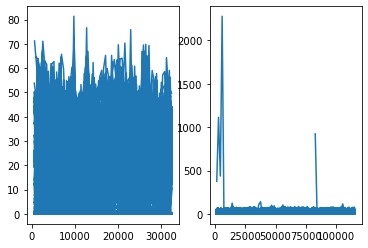

In [36]:
fix, (ax1, ax2) = plt.subplots(ncols=2) 

gdf_night['speed_km_h'].plot(ax=ax1)
gdf_day['speed_km_h'].plot(ax=ax2)



In [97]:
def remove_vehicle_extreme_speed(gdf, speed_max):

    set_vehicles = gdf.VehicleNumber.unique()
    remove = []
    for v in set_vehicles:
        if gdf[gdf["VehicleNumber"] == v].speed_km_h.max() > speed_max:
            remove.append(v)

    print(remove)
    
    list_indexes = np.array([], dtype='int64')
    for r in remove:
        index_names = gdf_day[gdf_day['VehicleNumber'] == r ].index
        list_indexes = np.concatenate([list_indexes, index_names.values])
    
    gdf = gdf.drop(list_indexes)

    return gdf

In [ ]:
gdf_day

In [ ]:
remove_vehicle_extreme_speed

In [93]:
list_indexes = np.array([], dtype='int64')

In [94]:
list_indexes = np.concatenate([list_indexes, index_names2.values])

In [95]:
list_indexes

array([ 64880,  82572,  84046,  85523,  89945,  91419,  92894,  94367,
        95845,  97320,  98800, 100275, 110593])

In [44]:
remove = [1907, 9825]

In [ ]:
index_names = df[ df['Age'] == 21 ].index
  
# drop these row indexes
# from dataFrame
df.drop(index_names, inplace = True)

In [64]:
index_names = gdf_day[gdf_day['VehicleNumber'] == 1907 ].index

In [74]:
type(index_names)

pandas.core.indexes.numeric.Int64Index

In [92]:
index_names2

Int64Index([ 64880,  82572,  84046,  85523,  89945,  91419,  92894,  94367,
             95845,  97320,  98800, 100275, 110593],
           dtype='int64')

In [66]:
index_names2 = gdf_day[gdf_day['VehicleNumber'] == 9825 ].index

In [70]:
import numpy as np

In [81]:
array = np.array

In [87]:
len(gdf_day)

112137

In [86]:
gdf_day.drop(ind)

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,Unnamed: 0,geometry,distance,TimeDelta,seconds,speed_m/s,speed_km_h
805,110,20.968691,742,2021-06-28 16:07:21,52.272133,1,805.0,POINT (7497862.988 5793178.124),NaN,NaT,NaN,NaN,NaN
2276,110,20.968685,742,2021-06-28 16:08:17,52.272137,1,805.0,POINT (7497862.578 5793178.570),0.604808,0 days 00:00:56,56.0,0.010800,0.038880
3753,110,20.968588,742,2021-06-28 16:11:21,52.272190,1,805.0,POINT (7497855.960 5793184.469),8.866186,0 days 00:03:04,184.0,0.048186,0.173469
5227,110,20.968618,742,2021-06-28 16:14:25,52.272160,1,807.0,POINT (7497858.006 5793181.131),3.915946,0 days 00:03:04,184.0,0.021282,0.076616
6703,110,20.968636,742,2021-06-28 16:17:29,52.272190,1,807.0,POINT (7497859.236 5793184.468),3.556846,0 days 00:03:04,184.0,0.019331,0.069590
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108446,L-6,20.898052,66525,2021-06-28 17:24:58,52.258049,1,731.0,POINT (7493039.281 5791615.520),3.785942,0 days 00:01:06,66.0,0.057363,0.206506
109920,L-6,20.898085,66525,2021-06-28 17:25:47,52.258015,1,731.0,POINT (7493041.529 5791611.734),4.403126,0 days 00:00:49,49.0,0.089860,0.323495
111394,L-6,20.898046,66525,2021-06-28 17:27:50,52.258072,1,731.0,POINT (7493038.875 5791618.080),6.878369,0 days 00:02:03,123.0,0.055922,0.201318
112867,L-6,20.898056,66525,2021-06-28 17:28:48,52.258057,1,731.0,POINT (7493039.555 5791616.410),1.803217,0 days 00:00:58,58.0,0.031090,0.111924


In [82]:
ind = np.concatenate([index_names.values, index_names2.values])

In [83]:
ind

array([   219,   1690,   3167,   4639,   6115,   7593,   9073,  10549,
        12027,  13505,  14984,  16456,  17933,  19408,  20884,  22361,
        23835,  25314,  26788,  28267,  29744,  31220,  32699,  34176,
        35652,  37130,  38602,  45986,  47464,  48942,  50419,  51895,
        53373,  54849,  56324,  57800,  59274,  60750,  62222,  63696,
        65170,  66641,  68118,  69592,  71066,  72536,  74009,  75481,
        76959,  78432,  79907,  81385,  82860,  84336,  85813,  87289,
        88761,  90233,  91710,  93182,  94657,  96136,  97611,  99089,
       100562, 102036, 103517, 104992, 106465, 107936, 109410, 110884,
       112357, 113833,  64880,  82572,  84046,  85523,  89945,  91419,
        92894,  94367,  95845,  97320,  98800, 100275, 110593])

In [59]:
gdf_day.drop(gdf_day[gdf_day['VehicleNumber' == remove]])

KeyError: False

In [55]:
gdf_day['VehicleNumber'] == remove

ValueError: ('Lengths must match to compare', (112137,), (2,))

In [57]:
gdf_day = gdf_day[~gdf_day[gdf_day['VehicleNumber'] == remove]]

ValueError: ('Lengths must match to compare', (112137,), (2,))

In [41]:
gdf_day = remove_vehicle_extreme_speed(gdf_day)

[1907, 9825]


KeyError: "None of [Int64Index([1907, 9825], dtype='int64')] are in the [columns]"

In [37]:
gdf_day = spacial_data_analysis_ztm.remove_vehicle_extreme_speed(gdf_day)

KeyError: "None of [Int64Index([1907, 9825], dtype='int64')] are in the [columns]"

In [ ]:
gdf_night = spacial_data_analysis_ztm.remove_vehicle_extreme_speed(gdf_night)

Po usunięciu tych danych rozkłady powinny wyglądać normalnie.

In [ ]:
fix, (ax1, ax2) = plt.subplots(ncols=2) 

gdf_night['speed_km/h'].hist(ax=ax1)
gdf_day['speed_km/h'].hist(ax=ax2)

_ = plt.plot()

###### Porównanie najwiekszej prędkości i średniej prędkości (dla wszystkich autobusów) z dnia na największą prędkość z nocy

In [ ]:
gdf_night = gdf_night.reset_index()

In [ ]:
gdf_day = gdf_day.reset_index()

In [ ]:
# noc
speed_max_night = gdf_night['speed_km_h'].max()

In [ ]:
# dzień
speed_max_day = gdf_day['speed_km_h'].max()

In [ ]:
av_speed_night = gdf_night['speed_km_h'].mean()

In [ ]:
av_speed_day = gdf_day['speed_km_h'].mean()

In [ ]:
# speed = [0.1, 17.5, 40, 48, 52, 69, 88]

# lifespan = [2, 8, 70, 1.5, 25, 12, 28]

# index = ['snail', 'pig', 'elephant', 'rabbit', 'giraffe', 'coyote', 'horse']

# df = pd.DataFrame({'speed': speed, 'lifespan': lifespan}, index=index)

# ax = df.plot.bar(rot=0)

In [ ]:
index = ['Night', 'Day']
df_sp_av = pd.DataFrame({'Top Speed': [speed_max_night, speed_max_day], 'Average Speed': [av_speed_night, av_speed_day]}, index=index)



In [ ]:
index = ['Top Speed', 'Average Speed']
df_sp_av = pd.DataFrame({'Night': [speed_max_night, av_speed_night], 'Day': [speed_max_day, av_speed_day]}, index=index)

In [ ]:
df_sp_av.plot.bar()

In [ ]:
# fix, (ax1, ax2) = plt.subplots(ncols=2) 


# speed_max = pd.Series([speed_max_night, speed_max_day])
# speed_ave = pd.Series([av_speed_night, av_speed_day])

# speed_max.bar(ax=ax1)
# speed_ave.hist(ax=ax2)
# # plt.hist([speed_max_night, speed_max_day], ax=ax1)
# # plt.hist([av_speed_night, av_speed_day], ax=ax2)
# _ = plt.plot()


#### Procent pomiarów prędkości pojazdów powyżej 50 km/h

In [ ]:
speeding_vehicles_night = spacial_data_analysis_ztm.return_vehicles_above_speed(gdf_night, 50)

In [ ]:
speeding_vehicles_day = spacial_data_analysis_ztm.return_vehicles_above_speed(gdf_day, 50)

In [111]:
vehicles_above = 0
for v in gdf_night.VehicleNumber.unique():
    if gdf_night[gdf_night['VehicleNumber'] == v]['speed_km_h'].max() > 50:
        vehicles_above += 1


In [114]:
speeding_vehicles_night = (vehicles_above/len(gdf_night.VehicleNumber.unique())) * 100

In [116]:
def return_vehicles_above_speed(gdf, speed_limit):
    vehicles_above = 0
    for v in gdf.VehicleNumber.unique():
        if gdf[gdf['VehicleNumber'] == v]['speed_km_h'].max() > speed_limit:
            vehicles_above += 1
            
    speeding_vehicles = (vehicles_above/len(gdf.VehicleNumber.unique())) * 100
    return speeding_vehicles

In [117]:
return_vehicles_above_speed(gdf_night, 50)

49.43181818181818

In [94]:
speeding_buses_night = gdf_night[gdf_night['speed_km_h'] > 50]

In [105]:
speeding_buses_day = gdf_night[gdf_night['speed_km_h'] > 50]

81.39289804045526

In [90]:
all_speeds_night = gdf_night[gdf_night['distance'].notna()]

In [92]:
all_speeds_night = len(all_speeds_night)

In [100]:
speeds_above_night = (len(speeding_buses_night)/all_speeds_night) * 100

In [101]:
speeds_above_night

3.246020804612107

In [102]:
all_speeds_day = gdf_day[gdf_day['distance'].notna()]

In [103]:
all_speeds_day = len(all_speeds_day)

In [106]:
speeds_above_day = (len(speeding_buses_day)/all_speeds_day) * 100

In [107]:
speeds_above_day

0.234024866271505

In [54]:
gdf_day.iloc[15927:15937]

,index,Lines,Lon,VehicleNumber,Time,Lat,Brigade,Unnamed: 0,geometry,distance,TimeDelta,seconds,speed_m/s,speed_km/h
15927,113832,251,21.045263,1906,2021-06-28 17:29:34,52.175081,52,220.0,POINT (7503096.186 5782380.307),63.041996,0 days 00:00:50,50.0,1.260840,4.539024
15928,219,139,21.848253,1907,2021-06-28 16:07:16,52.223384,54,219.0,POINT (7557960.933 5788092.824),NaN,NaT,NaN,NaN,NaN
15929,1690,139,21.939664,1907,2021-06-28 16:08:16,52.220501,54,219.0,POINT (7564211.057 5787849.131),6254.873131,0 days 00:01:00,60.0,104.247886,375.292388
15930,3167,139,22.405142,1907,2021-06-28 16:11:16,51.810956,54,219.0,POINT (7596898.585 5742801.297),55657.720150,0 days 00:03:00,180.0,309.209556,1113.154403
15931,4639,139,22.630547,1907,2021-06-28 16:14:17,51.671944,54,219.0,POINT (7612787.264 5727660.814),21947.308453,0 days 00:03:01,181.0,121.255848,436.521052
15932,6115,139,21.084335,1907,2021-06-28 16:17:26,52.163698,54,219.0,POINT (7505770.372 5781116.266),119624.832391,0 days 00:03:09,189.0,632.935621,2278.568236
15933,7593,139,21.084472,1907,2021-06-28 16:18:26,52.162945,54,219.0,POINT (7505779.850 5781032.419),84.381172,0 days 00:01:00,60.0,1.406353,5.062870
15934,9073,139,21.085237,1907,2021-06-28 16:19:21,52.161686,54,219.0,POINT (7505832.324 5780892.401),149.527308,0 days 00:00:55,55.0,2.718678,9.787242
15935,10549,139,21.086711,1907,2021-06-28 16:20:21,52.159775,54,219.0,POINT (7505933.457 5780679.933),235.309835,0 days 00:01:00,60.0,3.921831,14.118590
15936,12027,139,21.086711,1907,2021-06-28 16:21:01,52.159775,54,219.0,POINT (7505933.457 5780679.933),0.000000,0 days 00:00:40,40.0,0.000000,0.000000


Sortowanie czy sprawdzanie czy w której autobus jest dzielnicy (albo czy jest poza Warszawą)

In [48]:
for i in warsaw.index:
    pip = gdf_night.within(warsaw.loc[i, 'geometry'])
    gdf_night.loc[pip, 'Districs'] = warsaw.loc[i, 'name']
    

In [52]:
type(gdf_night)

geopandas.geodataframe.GeoDataFrame

In [53]:
bus = gdf_night.iloc[[829]]

In [54]:
bus

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,Unnamed: 0,geometry,distance,TimeDelta,seconds,speed_m/s,speed_km/h,Districs
61,735,21.045591,1509,2021-06-26 19:04:04,52.264248,M4,61.0,POINT (7503112.390 5792301.326),NaN,NaT,NaN,NaN,NaN,Praga Północ


NameError: name 'speeding_buses' is not defined

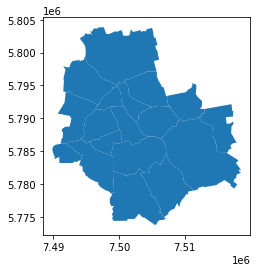

In [55]:
fig, ax = plt.subplots()
warsaw.plot(ax=ax)
speeding_buses.plot(ax=ax, color='red')

In [ ]:
pip = gdf.within(warsaw.loc[1, 'geometry'])

In [ ]:
gdf.loc[pip, 'dupa'] = 'dupa'

In [ ]:
gdf

In [ ]:
pip

In [ ]:
pip = gdf.within(pr_regions.loc[0, 'geometry'])

In [ ]:
pip = gdf.within(pr_regions.loc[0, 'geometry'])

#creating a new gdf keep only the intersecting records
so_pr = gdf.loc[pip].copy()

#assign region name 
so_pr['region'] = pr_regions.Name[0]

so_pr.head()

In [ ]:
set_vehicle_number = set(df["VehicleNumber"])
to_check_list = []
#
#                         .iloc[0:10]

In [ ]:
# set_vehicle_number

In [ ]:
for n in set_vehicle_number:
    if len(df[df["VehicleNumber"]==n]) > 5:
        to_check_list.append(n)
#         set_vehicle_number = set(df["VehicleNumber"])
#         to_check_list = []

In [ ]:
to_check_list

In [ ]:
lines

In [ ]:
gdf_ = gpd.GeoDataFrame()

In [ ]:
gdf_ = gpd.GeoDataFrame()
for bus_num in lines:
    print(bus_num)
    vehicle = gdf[gdf['VehicleNumber'] == bus_num]
    vehicle['distance'] = vehicle.distance(vehicle.shift())
#     y = s - s.shift()
    vehicle['TimeDelta'] = vehicle['Time'] - vehicle['Time'].shift()
    # here calculate timedeltas
    gdf_ = pd.concat([gdf_, vehicle])

return gdf_

In [ ]:
len(gdf_.drop_duplicates())

In [ ]:
gdf1.distance(gdf1.shift())

In [ ]:
for bus_num in gdf["VehicleNumber"]:
    print(bus_num)

In [ ]:
df[df['VehicleNumber'] == list_more7[0]]

In [ ]:
list_more7 = []
for i in range(1000, 9955):
    if len(df[df['VehicleNumber'] == i]) > 7:
        list_more7.append(i)
    

In [ ]:
list_more7[0]

In [ ]:
df

In [ ]:
import geopandas as gpd
from shapely.geometry import Point


geom=[Point(xy) for xy in zip([117.454361,117.459880],[38.8459879,38.846255])]
gdf=gpd.GeoDataFrame(geometry=geom,crs={'init':'epsg:4326'})
dis=gdf.distance(gdf.shift())
print(dis)

In [ ]:
df[df['VehicleNumber'] == list_more7[0]].iloc[1]['Time']

In [ ]:
df[df['VehicleNumber'] == list_more7[0]].iloc[2]['Time']

In [ ]:
import geopandas

In [ ]:
# Importing the great_circle module from the library
from geopy.distance import great_circle
  
# Loading the lat-long data for Kolkata & Delhi
kolkata = (22.5726, 88.3639)
delhi = (28.7041, 77.1025)
  
# Print the distance calculated in km
print(great_circle(kolkata, delhi).km)

In [ ]:
pl1 = (52.17152, 21.226742)

In [ ]:
pl2 = (52.171343, 21.226571)

In [ ]:
great_circle(pl1, pl2).m

In [ ]:
df['Time'] = pd.to_datetime(df['Time'])

In [ ]:
df

In [ ]:
df[df['VehicleNumber'] == list_more7[0]].iloc[1]['Time']

In [ ]:
delta = df[df['VehicleNumber'] == list_more7[0]].iloc[2]['Time'] - df[df['VehicleNumber'] == list_more7[0]].iloc[1]['Time']

In [ ]:
delta.seconds

In [ ]:
22.8769267442839/12

In [ ]:
1.9064105620236582 * (3600/1000)